In [12]:
system.time({source("paper_utils.R")})
library(presto)

   user  system elapsed 
  0.015   0.001   0.016 

# Load all cached results

In [3]:
cachedir <- "/data/srlab/ik936/NOTCH/data/cache/"
tissue <- readRDS(file.path(cachedir, "analysis_sc_tissue.rds"))
bulk <- readRDS('/data/srlab/ik936/NOTCH/data/cache/bulk_data.rds')
mouse <- readRDS('/data/srlab/ik936/NOTCH/data/cache/mouse.rds')

# Define color schemes and nice names

In [19]:
unique(dge_notch$group)

[1] "arterial"      "bcell"         "chondrocytes"  "intermediate" 
 [5] "lining"        "myeloid"       "neutrophil"    "pericyte_VSMC"
 [9] "perivascular"  "sublining"     "tcell"         "venous"

In [25]:
nice_name <- c(pericytes = "Pericytes", lining = "Lining Fibroblasts", sublining = "Sublining Fibroblasts", 
               sublining_cd34 = "Sublining Fibroblasts", endothelial = "Blood Vessel Cells", 
               oa = "Tissue OA", ra = "Tissue RA", MM1 = "fibroblast organoid", 
               MM2 = "fibroblast + blood vessel\norganoid", Tissue = "synovial tissue", 
              endo_st = "blood vessel cells", 
                peri_st = "pericytes", 
                endo_mm = "blood vessel cells",
                peri_mm = "fibroblasts + pericytes",
               primary = "Synovial Tissue", culture = "Organoid",
               blood = "Blood vessel cells", lymph = "Lymphatic vessel cells"
)
nice_names <- data.frame(nice_name, stringsAsFactors = FALSE) %>% tibble::rownames_to_column("given_name")
nice_names_list <- nice_name

given_name,nice_name
<chr>,<chr>
pericytes,Pericytes
lining,Lining Fibroblasts
sublining,Sublining Fibroblasts
sublining_cd34,Sublining Fibroblasts
endothelial,Blood Vessel Cells
oa,Tissue OA
ra,Tissue RA
MM1,fibroblast organoid
MM2,fibroblast + blood vessel organoid


In [26]:
# nice_names <- data.frame()
names_list_mouse <- c(arterial = 'Arterial EC', venous = 'Venous EC', chondrocytes = 'Chondrocytes', 
                intermediate = 'Intermediate Fibroblasts', 'lining' = 'Lining Fibroblasts', myeloid = 'Myeloid', 
                neutrophil = 'Neutrophils', pericyte_VSMC = 'Mural cells', sublining = 'Sublining Fibroblasts', 
                tcell = 'T cells', bcell = 'B cells', perivascular = 'Perivascular Fibroblasts')
nice_names_mouse <- data.frame(nice_name = names_list_mouse, stringsAsFactors = FALSE) %>% 
    tibble::rownames_to_column('given_name')

In [27]:
nice_names <- rbind(nice_names, nice_names_mouse)

# Figure 1

In [4]:
plt1 <- list()

## 1a 


In [261]:
fig.size(4, 7)
with(tissue, {
    meta_use <- meta_data %>% 
        dplyr::mutate(
            cell_type = case_when(cell_type %in% c('lymph', 'blood') ~ 'Vascular Endothelial Cells',
                      cell_type == 'leukocytes' ~ 'leukocytes', 
                      cell_type == 'pericytes' ~ 'Pericytes', 
                      cell_type == 'sublining' ~ 'Sublining Fibroblasts', 
                      cell_type == 'lining' ~ 'Lining Fibroblasts')
        )
    do_scatter(umap_harmony, meta_use, 'cell_type', pt_size = 3, no_guides = FALSE,
                              palette_use = tableau_color_pal()(6), do_labels = FALSE) + 
    labs(title = "Cell types") + 
    NULL    
    
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/umap_types.pdf', device = "pdf", 
           dpi = 300, width = 7, height = 4, useDingbats = FALSE)    
    
})
    

## 1b Pseudotime

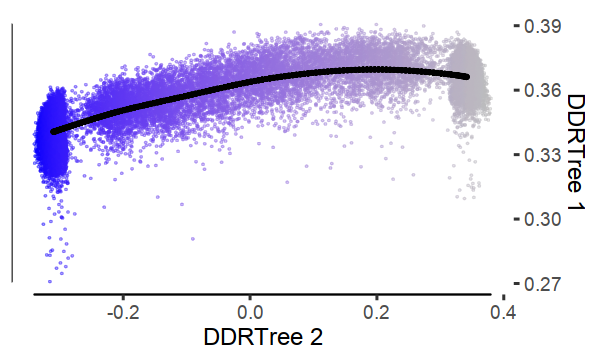

In [58]:
fig.size(3, 5)
(plt1$ddrtree <- data.frame(tissue$ddrtree_res$Z) %>% 
    cbind(tissue$meta_data %>% subset(cell_type %in% c("lining", "sublining"))) %>%
    ggplot(aes(-X2, X1)) + 
        geom_point_rast(dpi = 300, width = 5, height = 3, size = .5, aes(color = 100 - time), alpha = .4) + 
        geom_point_rast(dpi = 300, width = 5, height = 3, data = data.frame(t(tissue$ddrtree_res$Y))) + 
        theme_tufte(base_size = 14) + geom_rangeframe(color = "black") + 
        labs(x = "DDRTree 2", y = "DDRTree 1") + 
        scale_color_gradient2(mid = "blue", high = "grey", midpoint = 0) + 
        scale_y_continuous(position = "right") +   
         guides(color = FALSE) + 
        NULL
)

ggsave('/data/srlab/ik936/NOTCH/paper/figure1/ddrtree.pdf', plot = plt1$ddrtree, device = "pdf", 
       dpi = 300, width = 5, height = 3, useDingbats = FALSE)

## 1c UMAP: cell types + gradient

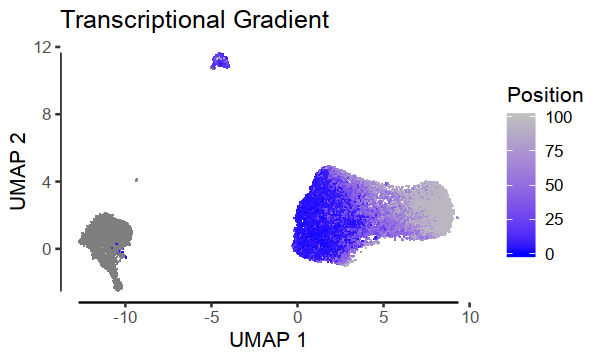

In [21]:
fig.size(3, 5)
(plt1$umap_main <- tissue$umap_harmony %>%
    cbind(tissue$meta_data) %>% 
    subset(cell_type != "leukocytes") %>% 
    dplyr::inner_join(nice_names, by = c("cell_type" = "given_name")) %>%
    ggplot(aes(`1`, `2`, color = 100 - time)) + 
        geom_point(shape = '.') + 
        scale_color_gradient2(mid = "blue", high = "grey", midpoint = 0) + 
        theme_tufte(base_size = 12, base_family = 'Helvetica') + geom_rangeframe(color = "black") + 
        labs(title = "Transcriptional Gradient", color = "Position", x = "UMAP 1", y = "UMAP 2") + 
        NULL
)


ggsave('/data/srlab/ik936/NOTCH/paper/figure1/umap_main.pdf', plot = plt1$umap_main, device = "pdf", 
       dpi = 300, width = 5, height = 3, useDingbats = FALSE)

## 1d Expression vs pseudotime

In [816]:
bin_95 <- function (data_df, xvar, yvars, num.bin, .include.lowest = TRUE) 
{
    data_df <- data.frame(data_df)
    x <- data_df[[xvar]]
    .breaks <- unique(quantile(x, probs = seq(0, 1, length.out = num.bin)))
    bin_means <- 0.5 * (head(.breaks, -1) + tail(.breaks, -1))
    bins_freq <- cut(x, .breaks, include.lowest = .include.lowest)
    levels(bins_freq) <- bin_means
    xmeans <- lapply(split(x, as.integer(bins_freq)), mean) %>% 
        as.numeric
    res_df <- Reduce(rbind, lapply(yvars, function(yvar) {
        y <- data_df[[yvar]]
        ymeans <- lapply(split(y, as.integer(bins_freq)), mean) %>% 
            as.numeric
        ysd <- lapply(split(y, as.integer(bins_freq)), sd) %>% 
            as.numeric
        data.frame(xval = xmeans) %>% cbind(Reduce(rbind, lapply(split(y, 
            as.integer(bins_freq)), function(.x) quantile(.x, 
            c(0.05, 0.95)))) %>% data.frame() %>% dplyr::mutate(symbol = yvar)) %>% 
            cbind(yval = ymeans, ysd = ysd)
    })) %>% data.frame()
    return(res_df)
}                                   

In [318]:
bulk$dge_dll4 %>% subset(logFC > 0 & adj.P.Val < .05) %>% nrow
bulk$dge_jag1 %>% subset(logFC > 0 & adj.P.Val < .05) %>% nrow

[1] 111

[1] 45

In [314]:
data.table(tissue$meta_data)[cell_type == 'pericytes', .(mean(100 - time), sd(100 - time))]

V1,V2
20.60889,11.68554


In [323]:
markers <- c("PRG4", "THY1")
with(tissue, {
    idx_use <- which(meta_data$cell_type %in% c("lining", "sublining"))
    markers <- c("PRG4", "THY1")
    ldata <<- data.frame(time = meta_data[idx_use, "time"], t(as.matrix(exprs_norm[markers, idx_use]))) %>% 
    bin_95("time", markers, 1e2)
})


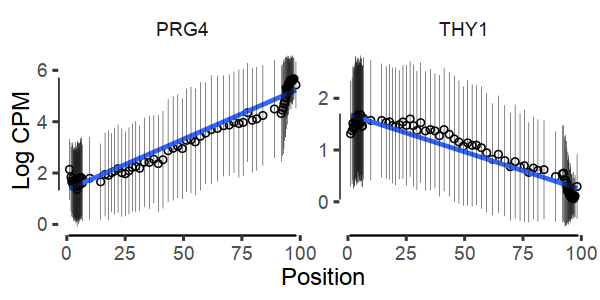

In [324]:
fig.size(2.5, 5)
(plt1$pseudotime_markers <- ldata %>% 
    ggplot(aes(100 - xval, yval)) + 
         geom_point(shape = 21) + 
#          geom_point(shape = ".") + 
        geom_smooth(method = "lm") + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd), size = .1) +
        facet_wrap(~symbol, scales = "free_y", nrow = 1) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + geom_rangeframe() + 
        labs(y = "Log CPM", x = "Position")
)    


ggsave('/data/srlab/ik936/NOTCH/paper/figure1/pseudotime_markers.pdf', plot = plt1$pseudotime_markers, device = "pdf", 
       dpi = 300, width = 5, height = 2.5, useDingbats = FALSE)

In [413]:
with(tissue, {
    idx_use <- which(meta_data$cell_type %in% c("lining", "sublining"))
    markers <- c("PRG4", "THY1")
    ldata <- data.frame(time = meta_data[idx_use, "time"], t(as.matrix(exprs_norm[markers, idx_use])))
    print(head(ldata))
    
    cor.test(~ time + PRG4, ldata, method = 'spearman') %>% broom::tidy() %>% print()
    cor.test(~ time + THY1, ldata, method = 'spearman') %>% broom::tidy() %>% print()
    
})

                            time     PRG4     THY1
AAACCTGAGACAAAGG_BWH075 24.55933 3.535234 0.000000
AAACCTGAGGTAGCCA_BWH075 97.77696 0.000000 2.363350
AAACCTGCAATCTGCA_BWH075 94.76058 2.676339 0.000000
AAACCTGCATTATCTC_BWH075 13.16606 3.726049 0.000000
AAACCTGGTAAACCTC_BWH075 52.32442 1.498020 0.000000
AAACCTGGTACCGCTG_BWH075 75.66847 3.285495 2.698028


Warning message in cor.test.default(x = c(24.5593295035345, 97.7769579428536, 94.7605829240305, :
“Cannot compute exact p-value with ties”

# A tibble: 1 x 5
  estimate statistic p.value method                          alternative
     <dbl>     <dbl>   <dbl> <chr>                           <chr>      
1   -0.670   5.61e12       0 Spearman's rank correlation rho two.sided  


Warning message in cor.test.default(x = c(24.5593295035345, 97.7769579428536, 94.7605829240305, :
“Cannot compute exact p-value with ties”

# A tibble: 1 x 5
  estimate statistic p.value method                          alternative
     <dbl>     <dbl>   <dbl> <chr>                           <chr>      
1    0.469   1.78e12       0 Spearman's rank correlation rho two.sided  


## 1e Proportions

Joining, by = "donor"


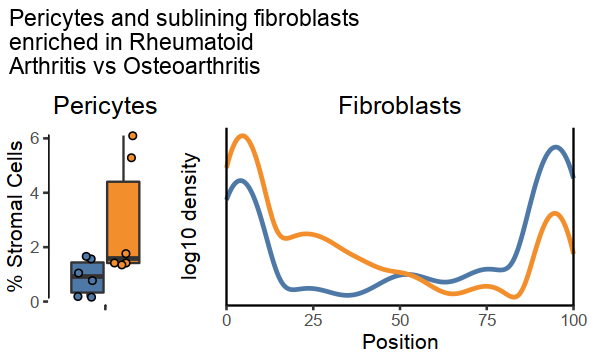

In [185]:
.x <- tissue$meta_data %>% 
    subset(cell_type != "leukocytes") %>% 
    with(table(cell_type, donor)) %>% prop.table(2)

fig.size(3, 5)
(plt1$proportions <- data.table(.x) %>% 
    dplyr::inner_join(unique(tissue$meta_data[, c("donor", "disease")])) %>% 
    dplyr::mutate(disease = ifelse(grepl("^OA", donor), "Osteoarthritis", "Rheumatoid Arthritis")) %>% 
    dplyr::mutate(cell_type = factor(cell_type, c("lining", "sublining", "pericytes", "endothelial"))) %>% 
    subset(cell_type == "pericytes") %>% 
    ggplot(aes(cell_type, 100 * N, fill = disease)) + 
        geom_boxplot() + 
        geom_point(shape = 21, position = position_jitterdodge(.75, jitter.height = 0, jitter.width = .2)) + 
        theme_tufte(base_size = 12, base_family = 'Helvetica') + 
        geom_rangeframe() + 
        guides(fill = FALSE) + 
        scale_fill_tableau() +
        theme(
            axis.text.x = element_blank(),
#             axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5), 
            strip.text = element_blank(), 
            plot.title = element_text(hjust = .5)
        ) + 
        scale_x_discrete(labels = nice_names_list) + 
        labs(y = "% Stromal Cells", x = "", title = "Pericytes") + 
tissue$meta_data %>% 
    subset(cell_type %in% c("lining", "sublining")) %>% 
#     dplyr::mutate(time_section = cut(100 - time, c(0, 15, 85, 100), include.lowest = TRUE)) %>% 
    ggplot(aes(100 - time)) + 
        geom_line(stat="density", aes(color = disease), size = 1) + scale_color_tableau() +  
    geom_vline(xintercept = c(0, 100)) + 
#         geom_density(aes(color = disease), size = 1) + scale_color_tableau() + 
#         geom_density(aes(fill = disease), alpha = .4) + scale_fill_tableau() +   
    theme_tufte(base_size = 12, base_family = 'Helvetica') +
    geom_rangeframe(color = "black") + 
    guides(color = FALSE, fill = FALSE) + 
    labs(color = "Position", x = "Position", y = "log10 density", title = 'Fibroblasts') + 
    theme(axis.ticks.y = element_blank(), 
          axis.text.y = element_blank(), 
         plot.title = element_text(hjust = .5)) + 
#           panel.background = element_rect()) + 
#     scale_x_continuous(breaks = seq(0, 100, 5)) + 
#     scale_x_continuous(breaks = c(0, 15, 85, 100)) + 
    scale_y_log10() + 
    plot_layout(widths = c(.3, 1)) + 
    plot_annotation(
        title = 'Pericytes and sublining fibroblasts\nenriched in Rheumatoid\nArthritis vs Osteoarthritis'
    ) + 
#     facet_wrap(~time_section, nrow = 1, scales = "free") + 
    NULL

)

ggsave('/data/srlab/ik936/NOTCH/paper/figure1/proportions.pdf', plot = plt1$proportions, device = "pdf", 
       dpi = 300, width = 5, height = 3, useDingbats = FALSE)

In [190]:
data_df <- data.table(.x) %>% 
    dplyr::inner_join(unique(tissue$meta_data[, c("donor", "disease")])) %>% 
    dplyr::mutate(disease = ifelse(grepl("^OA", donor), "Osteoarthritis", "Rheumatoid Arthritis")) %>% 
    dplyr::mutate(cell_type = factor(cell_type, c("lining", "sublining", "pericytes", "endothelial"))) %>% 
    subset(cell_type == "pericytes") 


wilcox.test(N ~ disease, data_df)

Joining, by = "donor"



	Wilcoxon rank sum test

data:  N by disease
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0


## 1g

In [ ]:
data_if <- fread("/data/srlab/ik936/NOTCH/paper/if_distances.txt")

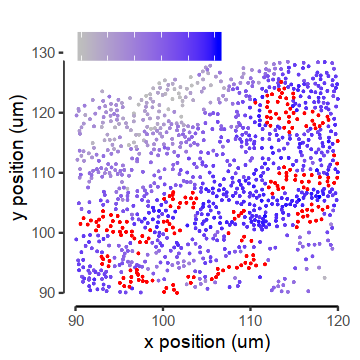

In [32]:
fig.size(3, 3)
(plt1$if_scatter <- data_if %>% 
    subset(Sample == 'RA195' & Image.number == 2) %>% 
    subset(center_x >= .9 & center_x <= 1.2 & center_y >= .9 & center_y <= 1.3) %>% 
    ggplot(aes(100 * center_x, 100 * center_y)) + 
        geom_point_rast(
            data = . %>% subset(is_ec != 1), aes(color = ratio), size = .5,
            dpi = 300, width = 3, height = 3
        ) + ## non-ECs
        geom_point_rast(
            data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', size = .5, 
            dpi = 300, width = 3, height = 3
        ) + ## EC cells
        theme_tufte() + geom_rangeframe() + 
        scale_color_gradient2(
            mid = "grey", high = "blue", midpoint = -3, 
            guide = guide_colorbar(
                direction = "horizontal", title.position = "top",
                label.position = "bottom", label.hjust = 0.5, 
                label.vjust = 0.5,
                label.theme = element_blank()
            )
        ) + 
        guides(area = FALSE, size = FALSE) + 
        labs(color = '') + 
        labs(x = 'x position (um)', y = 'y position (um)') + 
        scale_x_continuous(breaks = seq(0, 200, 10)) + 
        scale_y_continuous(breaks = seq(0, 200, 10), limits = c(90, 135)) + 
        theme(legend.position = c(0.3, .9)) + 
        NULL
)

ggsave('/data/srlab/ik936/NOTCH/paper/figure1/if_scatter.pdf', plot = plt1$if_scatter, device = "pdf", 
       dpi = 300, width = 3, height = 3, useDingbats = FALSE)

## 1h 

In [14]:
data_if_binned <- data_if %>% 
    subset(Sample == "RA195" & Image.number == 2) %>% 
    subset(!is.na(dist_EC2)) %>% 
    bin_95("dist_EC2", c("CD146", "ratio"), 100)

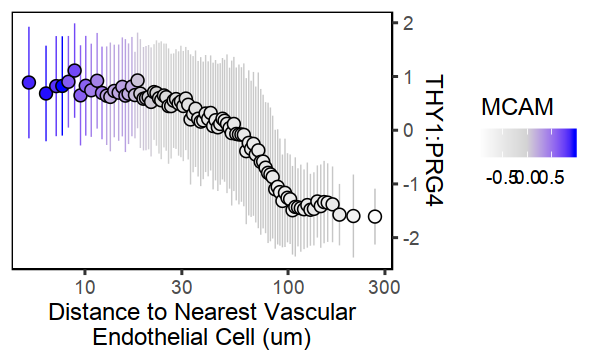

In [57]:
fig.size(3, 5)
(plt1$if_corr <- data_if_binned %>% 
    subset(symbol == "ratio") %>% 
    cbind(    
        MCAM = data_if_binned %>% subset(symbol == "CD146") %>% with(yval)    
    ) %>% 
    ggplot(aes(xval, yval)) + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd, color = MCAM), size = .3) +
        geom_point(shape = 21, size = 3, aes(fill = MCAM)) + 
        scale_color_gradient2(low = "grey", high = "blue", mid = "lightgrey") + 
        scale_fill_gradient2(
            low = "white", high = "blue", mid = "lightgrey",
                    guide = guide_colorbar(
                        direction = "horizontal", title.position = "top",
                        label.position = "bottom", label.hjust = 0.5, 
                        label.vjust = 0.5, barwidth = 4,
                    )
        ) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        theme(panel.background = element_rect()) + 
        labs(y = "THY1:PRG4", x = "Distance to Nearest Vascular\nEndothelial Cell (um)") + 
        guides(color = FALSE) + 
        scale_y_continuous(position = "right") + 
        scale_x_log10() + 
        NULL
)

ggsave('/data/srlab/ik936/NOTCH/paper/figure1/if_corr.pdf', plot = plt1$if_corr, device = "pdf", 
       dpi = 300, width = 5, height = 3, useDingbats = FALSE)

# Figure 2

## 2ab

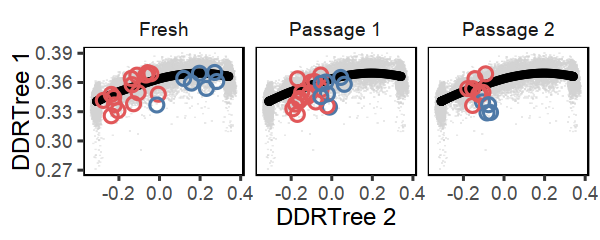

In [49]:
fig.size(2, 5)
with(bulk, {
(    p1 <<- ddr_stim %>% data.frame() %>% 
        cbind(metadata) %>% 
        subset(Experiment == 'Fibroblast stability') %>% 
        dplyr::mutate(condition = ifelse(condition == "Day7/8", "Passage 1", condition)) %>% 
        dplyr::mutate(condition = ifelse(condition == "Day 14", "Passage 2", condition)) %>%             
        dplyr::mutate(condition = factor(condition, c("Fresh", "Passage 1", "Passage 2"))) %>%
        dplyr::mutate(Cell.type = as.character(Cell.type)) %>% 
        dplyr::mutate(Cell.type = ifelse(grepl("CD34", Cell.type), "CD90+", Cell.type)) %>% 
        subset(Cell.type != 'CD146+') %>% 
        ggplot(aes(-X2, X1, color = Cell.type)) +
            geom_point_rast(dpi = 300, height = 1, width = 1, 
                data = tissue$ddrtree_res$Z %>% data.frame(), 
                color = 'lightgrey', alpha = .5, shape = '.'
            ) + 
            geom_point(data = data.frame(t(tissue$ddrtree_res$Y)), color = 'black') + 
            geom_point(shape = 21, size = 3, position = position_jitter(height = .02), stroke = 1) + 
            labs(x = "DDRTree 2", y = "DDRTree 1") + 
            theme_tufte(base_size = 14, base_family = "Helvetica") + 
            theme(panel.background = element_rect()) + 
            scale_color_manual(values = c(tableau_color_pal()(10)[1], tableau_color_pal()(10)[3])) + 
            guides(color = FALSE) + 
            facet_wrap(~condition) + 
            NULL
  )  
})

# ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/if_scatter', device = "pdf", 
#        dpi = 300, width = 16, height = 10, useDingbats = FALSE)  


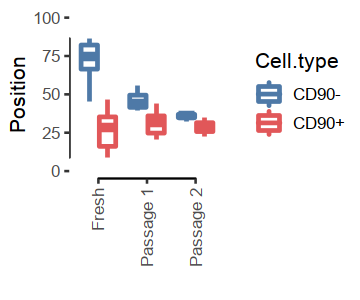

In [50]:
fig.size(2.5, 3)
with(bulk, {
(    p2 <<- metadata %>% 
        subset(Experiment == 'Fibroblast stability') %>% 
        dplyr::mutate(condition = ifelse(condition == "Day7/8", "Passage 1", condition)) %>% 
        dplyr::mutate(condition = ifelse(condition == "Day 14", "Passage 2", condition)) %>%             
        dplyr::mutate(condition = factor(condition, c("Fresh", "Passage 1", "Passage 2"))) %>%
        dplyr::mutate(Cell.type = as.character(Cell.type)) %>% 
        dplyr::mutate(Cell.type = ifelse(grepl("CD34", Cell.type), "CD90+", Cell.type)) %>% 
        subset(Cell.type != 'CD146+') %>% 
        ggplot(aes(condition, 100 - time, color = Cell.type)) + 
        geom_boxplot(outlier.shape = NA, lwd=1) + 
        theme_tufte(base_size = 12) + geom_rangeframe(col = "black") + 
        theme(plot.title = element_text(size = 14, hjust = .5), 
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
#         scale_fill_manual(values = c(tableau_color_pal()(10)[3], tableau_color_pal()(10)[1])) + 
            scale_color_manual(values = c(tableau_color_pal()(10)[1], tableau_color_pal()(10)[3])) + 
#         scale_color_manual(values = c(tableau_color_pal()(10)[8], tableau_color_pal()(10)[1])) + 
#         scale_color_manual(values = c(tableau_color_pal()(10)[3], tableau_color_pal()(10)[1])) + 
#         scale_fill_tableau() +
        ylim(0, 100) + 
        labs(x = "", y = "Position")
)    
})


In [51]:
with(bulk, {
    metadata %>% 
        subset(Experiment == 'Fibroblast stability') %>% 
        dplyr::mutate(condition = ifelse(condition == "Day7/8", "Passage 1", condition)) %>% 
        dplyr::mutate(condition = ifelse(condition == "Day 14", "Passage 2", condition)) %>%             
        dplyr::mutate(condition = factor(condition, c("Fresh", "Passage 1", "Passage 2"))) %>%
        dplyr::mutate(Cell.type = as.character(Cell.type)) %>% 
        dplyr::mutate(Cell.type = ifelse(grepl("CD34", Cell.type), "CD90+", Cell.type)) %>% 
        subset(Cell.type != 'CD146+') %>% 
    with(table(Cell.type, condition))
        
})

         condition
Cell.type Fresh Passage 1 Passage 2
    CD90-     7         7         4
    CD90+    15        16         8

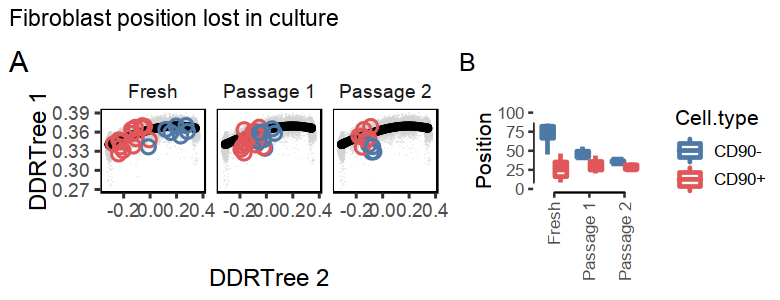

In [53]:
fig.size(2.5, 6.5)
p1 + 
p2 + 
plot_layout(nrow = 1, widths = c(3, 1)) +
    patchwork::plot_annotation(title = "Fibroblast position lost in culture", tag_levels = 'A')

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/stability.pdf', device = "pdf", 
       dpi = 300, width = 6.5, height = 2.5, useDingbats = FALSE)  


## 2f: MM cell types UMAP

In [415]:
joint <- readRDS(file.path(cachedir, "analysis_sc_tissue_mm.rds"))

In [138]:
100 * (joint$umap_projected[which(joint$meta_data$donor == "MM2"), 1] %>% cut(c(-20, -7, -2, 2, 10)) %>% table %>% prop.table)
100 * (joint$umap_projected[which(joint$meta_data$donor == "MM2" & joint$meta_data$cell_type != "blood"), 1] %>% cut(c(-20, -7, -2, 2, 10)) %>% table %>% prop.table)
100 * (joint$umap_projected[which(joint$meta_data$donor == "MM1"), 1] %>% cut(c(-20, -7, -2, 2, 10)) %>% table %>% prop.table)


.
 (-20,-7]   (-7,-2]    (-2,2]    (2,10] 
14.643545 13.921002  4.672447 66.763006 

.
  (-20,-7]    (-7,-2]     (-2,2]     (2,10] 
 0.1127396 16.2908681  5.4678692 78.1285231 

.
  (-20,-7]    (-7,-2]     (-2,2]     (2,10] 
 0.0000000  0.0000000  0.1383764 99.8616236 

In [418]:
fig.size(5, 5)
with(joint, {
    idx_mm <- which(meta_data$source == "culture")
    idx_pr <- which(meta_data$source == "primary" & meta_data$cell_type %in% c("lining", "sublining"))
    
    plt_df <- joint$umap_projected %>% 
        data.frame() %>% 
        cbind(joint$meta_data) %>% 
        dplyr::mutate(label = ifelse(source == 'culture', donor, disease)) %>% 
        dplyr::mutate(label = ifelse(grepl("^MM", donor), donor, "synovial tissue")) %>% 
        dplyr::arrange(source == "culture") %>% ## put MM cells on top
        dplyr::mutate(label = ifelse(label == "MM1", "fibroblast", label)) %>% 
        dplyr::mutate(label = ifelse(label == "MM2", "fibroblast + blood vessel", label)) 
    
    plt_df %>% 
        subset(source == "culture") %>% 
        ggplot(aes(X1, X2)) +
            guides(color = FALSE) + 
            geom_point_rast(width = 5, height = 5, dpi = 300,
                color = "lightgrey", 
                data = plt_df %>% subset(source == 'primary') %>% dplyr::select(-label), 
                shape = '.', alpha = .5
            ) + 
            geom_point_rast(
                data = . %>% subset(source == "culture"), aes(color = label),
                dpi = 300, width = 6, height = 4, size = .5
            ) + 
            labs(x = "UMAP 1", y = "UMAP 2") + 
#             labs(x = "DDRTree 2", y = "DDRTree 1", title = "Fibroblast + Blood Vessel Organoid") + 
            scale_color_manual(values = c(`synovial tissue` = "grey", MM1 = '#F28E2B', MM2 = '#F28E2B', 
                                          `fibroblast` = '#F28E2B', `fibroblast + blood vessel` = '#F28E2B')) + 
            theme_tufte(base_size = 14, base_family = "Helvetica") + #geom_rangeframe(color = "black") + 
            theme(panel.background = element_rect(), strip.text = element_blank()) + 
            scale_y_continuous(position = "right") + 
            facet_wrap(~label, ncol = 1) + 
            NULL
    
    ggsave('/data/srlab/ik936/NOTCH/paper/figure2/umap_mm.pdf', device = "pdf", 
           dpi = 300, width = 4, height = 5, useDingbats = FALSE)    
})



# Figure 3

## 3ab: Ligand-Receptor dreamcatcher

In [159]:
library(circlize)

In [156]:
do_circos <- function(lr_df, significant_pairs, targets_bold) {
    genes_remove <- intersect(lr_df$ligand, lr_df$receptor) ## remove the rare genes that is both ligand and receptor
    significant_pairs %<>% 
        subset(!ligand %in% genes_remove & !receptor %in% genes_remove)    

    ## set up adjacency matrix
    mat <- lr_df %>% 
#         head(40) %>% 
        dplyr::select(ligand, receptor) %>% 
        dplyr::mutate(dummy = 1) %>% 
        tidyr::spread(ligand, dummy, fill = 0)         
    row.names(mat) <- mat$receptor
    mat$receptor <- NULL
    mat %<>% as.matrix()    

    ## space out the gene names that will be printed so they don't overlap
    ## this also minimizes crossing of significant lines
    ## first for receptors    
    target_receptors <- unique(significant_pairs$receptor)
    idx_rownames <- round(seq(quantile(1:nrow(mat), .35), 
                              quantile(1:nrow(mat), .65), 
                              length.out = length(target_receptors)))
    new_rownames <- rep("", nrow(mat))
    new_rownames[idx_rownames] <- target_receptors
    new_rownames[setdiff(1:nrow(mat), idx_rownames)] <- sample(setdiff(row.names(mat), target_receptors))

    
    ## then for ligands
    target_ligands <- rev(unique(significant_pairs$ligand))
    idx_colnames <- round(seq(quantile(1:ncol(mat), .35), 
                              quantile(1:ncol(mat), .65), 
                              length.out = length(target_ligands)))
    new_colnames <- rep("", ncol(mat))
    new_colnames[idx_colnames] <- target_ligands
    new_colnames[setdiff(1:ncol(mat), idx_colnames)] <- sample(setdiff(colnames(mat), target_ligands))

    mat <- mat[new_rownames, new_colnames]
#     mat <- mat[sample(row.names(mat)), sample(colnames(mat))]
    
    ## highlight the target genes
    target_genes <- c(target_ligands, target_receptors)
    for (i in 1:nrow(significant_pairs)) {    
        mat[significant_pairs[[i, "receptor"]], significant_pairs[[i, "ligand"]]] <- 2
    }
    
    ## set line colors
    col_mat <- matrix(NA, nrow(mat), ncol(mat))
    col_mat[mat == 1] <- "lightgrey"
    col_mat[mat == 2] <- "black"

    ## set sector colors
    grid.col <- c(rep(tableau_color_pal()(10)[4], ncol(mat)), rep(tableau_color_pal()(10)[2], nrow(mat)))
#     grid.col <- c(rep("red", ncol(mat)), rep("blue", nrow(mat)))
    names(grid.col) <- c(colnames(mat), row.names(mat))

    circos.clear()
#     circos.par(gap.degree = 0)
    circos.par(start.degree = 90, clock.wise = FALSE, gap.after = 0)

    chordDiagram(
        mat,
        grid.col = grid.col, 
        col = col_mat,
        small.gap = 0,
        big.gap = 10,    
        link.rank = rank(mat),    
        annotationTrack = "grid", 
        preAllocateTracks = list(track.height = max(strwidth(unlist(dimnames(mat)))))
    )

    circos.track(track.index = 1, panel.fun = function(x, y) {
        xlim = get.cell.meta.data("xlim")
        xplot = get.cell.meta.data("xplot")
        ylim = get.cell.meta.data("ylim")
        sector.name = get.cell.meta.data("sector.index")

        if (sector.name %in% targets_bold & sector.name %in% target_genes) {
            circos.text(mean(xlim), ylim[1], sector.name, facing = "clockwise",
                niceFacing = TRUE, adj = c(0, 0.5), col = "red")            
        } else if (sector.name %in% target_genes) {
            circos.text(mean(xlim), ylim[1], sector.name, facing = "clockwise",
                niceFacing = TRUE, adj = c(0, 0.5), col = "black")
        } else {
            circos.text(mean(xlim), ylim[1], "")
        }
    }, bg.border = NA)
    circos.clear()
    
}

In [165]:
fig.size(3, 4)

thresh <- 10 #-log10(.05)
thresh_pct <- 0.1
targets_both <- dplyr::inner_join(tissue$lr_df_st, joint$lr_df_st, by = c("ligand", "receptor"), suffix = c("_st", "_mm")) %>% 
    subset(ligand_expr_st > thresh & receptor_expr_st > thresh & ligand_expr_mm > thresh & receptor_expr_mm > thresh & 
           ligand_pct_st > thresh_pct & receptor_pct_st > thresh_pct & ligand_pct_mm > thresh_pct & receptor_pct_mm > thresh_pct) %>% 
    with(unique(c(ligand, receptor)))

with(joint, {
    significant_pairs <- lr_df_st %>% 
        subset(ligand_expr > thresh & receptor_expr > thresh & 
               ligand_pct > thresh_pct & receptor_pct > thresh_pct)
    
pdf('/data/srlab/ik936/NOTCH/paper/figure2/lr_organoid.pdf', width = 4, height = 3) 
do_circos(lr_df_st, significant_pairs, targets_both)
dev.off()    
    
})

png 
  2

In [166]:
fig.size(3, 3)
with(tissue, {
    significant_pairs <- lr_df_st %>% 
        subset(ligand_expr > thresh & receptor_expr > thresh & 
               ligand_pct > thresh_pct & receptor_pct > thresh_pct)

    pdf('/data/srlab/ik936/NOTCH/paper/figure2/lr_tissue.pdf', width = 4, height = 3, paper='special') 
    do_circos(lr_df_st, significant_pairs, targets_both)
    dev.off()    
        
})


png 
  2

## 3c

In [312]:
plt_df <- tissue$meta_data %>% 
    cbind(t(as.matrix(tissue$exprs_norm[c('NOTCH1', 'NOTCH3'), ]))) %>% 
    tidyr::gather(feature, val, NOTCH1, NOTCH3)

fig.size(2, 8)
library(ggridges)
(plt <- plt_df %>% 
#     ggplot(aes(val, label_nice)) + 
#     ggplot(aes(val, cell_subtype)) + 
    subset(cell_subtype %in% c('lining', 'pericytes', 'Venous', 'Arterial', 'sublining')) %>% 
    subset(!cell_type %in% c('leukocytes', '', 'lymph')) %>% 
#     subset(!is.na(cell_type)) %>% 
    ggplot(aes(val, color = cell_type)) + 
#     ggplot(aes(val, color = cell_subtype)) + 
        geom_density(aes(y = ..scaled..)) + 
#         geom_density_ridges(aes(height =..ndensity..), scale = 1.2) + 
#         geom_density_ridges(scale = 1.2) + 
        theme_tufte(base_size = 12) + geom_rangeframe(color = 'black') + 
        scale_color_tableau() + 
#         geom_vline(xintercept = 0, linetype = 2) + 
#         labs(x = 'Notch activation score', y = '', title = 'Notch activation score') + 
        facet_wrap(~feature, scales = 'free_x') + 
        labs(y = 'Scaled Density', x = '') + 
        NULL)

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/human_notch_ridges.pdf', device = "pdf", plot = plt,
       dpi = 300, width = 8, height = 2, useDingbats = FALSE)  

## 3d: Ligand screen

In [379]:
ligands_df <- data.table(
    ligand = c('TGFB', 'BMP7', 'Activin A', 'Wnt3a', 'Wnt5a', 'JAG1', 'DLL4', 'EGF', 'PDGF-BB', 'IFNG', 'TNF'), 
    type = rep(c('Morphogen', 'Growth\nFactor', 'Cytokine'), c(7, 2, 2))
)

Joining, by = "ligand"


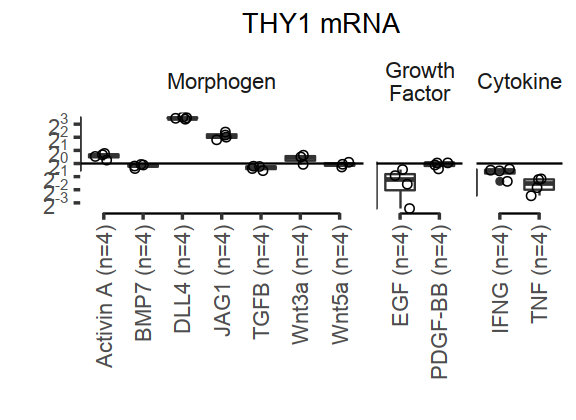

In [384]:
fig.size(3.5, 4.8)
plt_df <- fread("/data/srlab/ik936/NOTCH/data/Manuscript_data/Figure 3/Fig3D THY1 qPCR.txt") %>% 
    tidyr::gather(ligand, value) %>% 
    subset(!is.na(value)) %>% 
    dplyr::inner_join(ligands_df) %>% 
    dplyr::mutate(ligand = factor(ligand, ligands_df$ligand)) %>% 
    dplyr::mutate(type = factor(type, c('Morphogen', 'Growth\nFactor', 'Cytokine'))) %>% 
    identity()

plt_df %>% 
    ggplot(aes(sprintf('%s (n=4)', ligand), value)) + 
        geom_boxplot() + 
        geom_point(shape = 21, position = position_jitter(width = .25, height = 0), size = 2) + 
        facet_grid(.~type, scales = "free_x", space = "free_x") + 
        theme_tufte(base_size = 16, base_family = "Helvetica") + 
        geom_rangeframe() + 
        labs(y = '', x = '', title = 'THY1 mRNA') + 
        theme(plot.title = element_text(hjust = .5, size = 16)) + 
        geom_hline(yintercept = 1) + 
         scale_y_continuous(
             trans = 'log2',
             breaks = 2 ^ seq(-5, 5, 1), 
             labels = scales::trans_format("log2", scales::math_format(2^.x))
         ) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/ligand_screen.pdf', device = "pdf", 
       dpi = 300, width = 4.8, height = 3.5, useDingbats = FALSE)

In [523]:
data.table(plt_df)[, broom::tidy(t.test(value, mu=0)), by = ligand] %>% 
    dplyr::mutate(fdr = p.adjust(p.value)) %>% 
    subset(fdr < .05 & estimate > 2)

,ligand,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative,fdr
6,DLL4,11.048995,42.90044,2.787639e-05,3,10.229357,11.868633,One Sample t-test,two.sided,0.0002508875
7,JAG1,4.327108,11.50824,1.408521e-03,3,3.130505,5.523711,One Sample t-test,two.sided,0.0056340847


## 3h

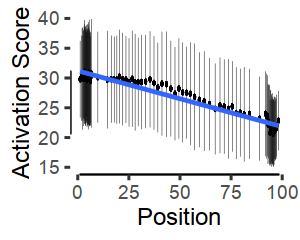

In [17]:
fig.size(2, 2.5)

idx_use <- which(tissue$meta_data$cell_type %in% c("lining", "sublining"))
ldata <- data.frame(time = tissue$meta_data[idx_use, "time"], tissue$meta_data[idx_use, ]) %>% 
    bin_95("time", c('score_notch'), 1e2)

ldata %>% 
    ggplot(aes(100 - xval, yval)) + 
        geom_point_rast(width = 5, height = 2, dpi = 300, size = 2) + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd), size = .1) +
#         facet_wrap(~symbol, scales = "free_y", nrow = 1) + 
#         facet_wrap(~symbol, scales = "free_y", nrow = 1) + 
        geom_smooth(method = "lm") + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + geom_rangeframe() + 
        labs(y = "Activation Score", x = "Position")

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/notch_activation_both.pdf', device = "pdf", 
       dpi = 300, width = 2.5, height = 2, useDingbats = FALSE)

In [775]:
cor.test(~ score_both + time, subset(.x, cell_type %in% c('lining', 'sublining')), method = 'spearman') %>% broom::tidy()


Warning message in cor.test.default(x = c(22.8459719844075, 31.9865304223769, 17.0500583753354, :
“Cannot compute exact p-value with ties”

estimate,statistic,p.value,method,alternative
0.4309641,1.913148e+12,0,Spearman's rank correlation rho,two.sided


## 3i

In [ ]:
fig.size(3, 2.5)
str <- "OA	RA
2.32	4.53
1.54	14
3.42	2.68
5.18	3.28
2.13	16.2
	8.91
	8.76
	13.2
	6.48
	6.51"
plt_df <- fread(text = str) %>% 
    tidyr::gather(key, val) %>% 
    subset(!is.na(val)) 

plt_df %>% 
    ggplot(aes(key, val)) + 
        geom_boxplot() + 
        geom_point(shape = 21, position = position_jitter(width = .25, height = 0), size = 2) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        geom_rangeframe() + 
        labs(y = "% NOTCH3+ Fibroblasts", x = "") + 
#         geom_text(x = .5, y = 15, label = sprintf("p=%.3f", broom::tidy(t.test(val ~ key, plt_df))$p.value), 
#                   hjust = 0, size = 6) + 
    #     theme(panel.background = element_rect()) + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/notch3_mfi_ra_oa.pdf', device = "pdf", 
       dpi = 300, width = 2.5, height = 3, useDingbats = FALSE)

In [855]:
data.table(plt_df)[, mean(val), by = key]

key,V1
<chr>,<dbl>
OA,2.918
RA,8.455


## 3j

In [91]:
cutoff <- tissue$meta_data %>% 
    subset(cell_type %in% c('lining')) %>% 
    with(quantile(score_notch, c(.95))) %>% 
    unlist %>% 
    as.numeric %>% 
    round(1)

plt_df <- data.table(tissue$meta_data)[, sum(score_notch > cutoff) / .N, by = .(disease, donor)] 



	Wilcoxon rank sum test

data:  V1 by disease
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Welch Two Sample t-test

data:  V1 by disease
t = -2.8203, df = 8.2643, p-value = 0.02177
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.36991464 -0.03813038
sample estimates:
mean in group oa mean in group ra 
      0.08081339       0.28483590 


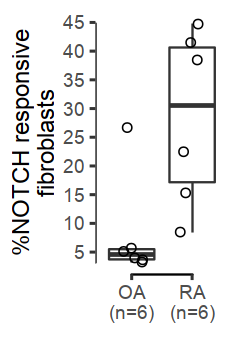

In [107]:
fig.size(3, 2)
plt_df %>% 
    dplyr::mutate(disease = case_when(
        disease == 'oa' ~ 'OA\n(n=6)',
        disease == 'ra' ~ 'RA\n(n=6)'
    )) %>% 
    ggplot(aes(disease, 100 * V1)) +
#         geom_point(shape = )
        geom_boxplot(outlier.shape = NA) + 
        geom_jitter(shape = 21, size = 2, width = .2) + 
        scale_y_continuous(breaks = seq(0, 100, 5)) + 
        theme_tufte(base_size = 14) + geom_rangeframe() + 
        labs(x = '', y = '%NOTCH responsive\nfibroblasts') + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/notch_activation_10x.pdf', device = "pdf", 
       dpi = 300, width = 2, height = 3, useDingbats = FALSE)

## 3k

In [111]:
with(bulk, {
    genes_dll4 <- dge_dll4 %>% subset(adj.P.Val < .05 & logFC > 0) %>% with(symbol) %>% 
        intersect(row.names(exprs_amp))
    genes_jag1 <- dge_jag1 %>% subset(adj.P.Val < .05 & logFC > 0) %>% with(symbol) %>% 
        intersect(row.names(exprs_amp))
    genes_both <- union(genes_dll4, genes_jag1)
    message(length(genes_jag1))
    message(length(genes_dll4))
    message(length(genes_both))
    
    score_amp <<- data.table(
        score_jag1 = Matrix::colSums(exprs_amp[genes_jag1, ]),
        score_dll4 = Matrix::colSums(exprs_amp[genes_dll4, ]),
        score_both = Matrix::colSums(exprs_amp[genes_both, ])
    ) %>% 
        cbind(meta_amp)
    
})

43
105
118


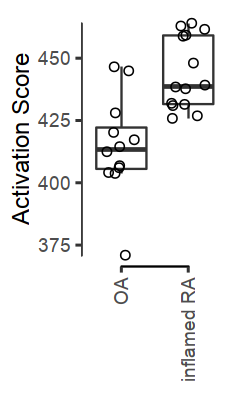

In [121]:
fig.size(3.5, 2)
plt_df <- score_amp %>% 
    dplyr::mutate(lym_25 = factor(lym_25, c('OA', 'inflamed RA'))) %>% 
    subset(!is.na(lym_25)) 

plt_df %>% 
    ggplot(aes(lym_25, score_both)) + 
        geom_boxplot(outlier.shape = NA) + 
        geom_point(shape = 21, size = 2, position = position_jitter(width = .25, height = 0)) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        geom_rangeframe() + 
        labs(y = "Activation Score", x = "") + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/notch_activation_amp_both.pdf', device = "pdf", 
       dpi = 300, width = 2, height = 3.5, useDingbats = FALSE)

In [120]:
test_df <- score_amp %>% 
    subset(lym_25 %in% c('OA', 'inflamed RA')) %>% 
    dplyr::mutate(lym_25 = factor(lym_25, c('OA', 'inflamed RA')))

test_df %>% dplyr::select(score_jag1, score_dll4, score_both) %>% t %>% 
    limma::lmFit(model.matrix(~lym_25, test_df)) %>% 
    limma::eBayes() %>% 
    limma::topTable(coef = 2, number = 5)


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
score_dll4,30.596148,387.7225,4.819083,4.991418e-05,0.0001497425,-1.434020
score_both,29.439374,430.4983,4.486947,1.216256e-04,0.0001824384,-1.732235
score_jag1,9.210433,150.6834,3.142870,4.045964e-03,0.0040459639,-3.006329


# Figure 4


## 4a

In [9]:
fig.size(2.5, 4)
with(mouse, {
(    plt <- do_scatter(umap_harmony, meta_data, 'cell_type',
#                nice_names = nice_names, 
               h = 3, w = 4, base_size = 12,
               palette_use = tableau_color_pal('Tableau 20')(20))
)
ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/mouse_umap_cell_types.pdf', device = "pdf", plot = plt,
       dpi = 300, width = 4, height = 2.5, useDingbats = FALSE)  

})


Warning message:
“Ignoring unknown parameters: label.size”

## 4b

In [219]:
# features <- paste0('Notch', 1:4)
features <- c('Notch3')

fig.size(2.5, 3.5)
with(mouse, {
    plotFeatures(exprs_norm, umap_harmony, order_by_expression = TRUE, no_guide = TRUE, w = 4 * 1, h = 3 * 1,
                 features, nrow = 2, qlo = 0, qhi = 1, pt_shape = 16, color_high = 'red')
})

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/mouse_notch_scatter.pdf', device = "pdf", 
       dpi = 300, width = 3.5, height = 2.5, useDingbats = FALSE)  

In [16]:
# dge_notch <- wilcoxauc(mouse$exprs_norm['Notch1', , drop = FALSE], mouse$meta_data$cell_type)
idx <- which(mouse$meta_data$label != 'KO')
dge_notch <- wilcoxauc(mouse$exprs_norm[c('Notch3', 'Notch1'), idx, drop = FALSE], mouse$meta_data$cell_type[idx])

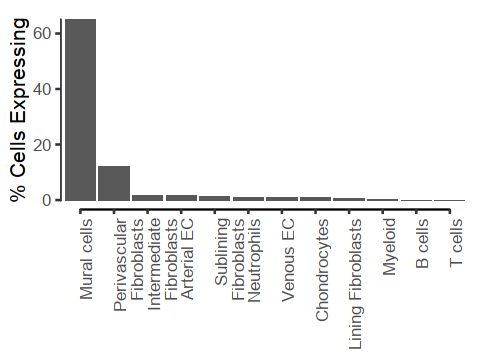

In [38]:
library(stringr)

fig.size(3, 4)
dge_notch %>% 
    subset(feature == 'Notch3') %>% 
    dplyr::inner_join(nice_names, by = c('group' = 'given_name')) %>% 
    dplyr::mutate(nice_name = str_wrap(nice_name, 20)) %>% 
    unique() %>% 
#     dplyr::arrange(-pct_in)

    ggplot(aes(reorder(nice_name, -pct_in), pct_in)) + 
        geom_bar(stat = 'identity') + 
        theme_tufte(base_size = 12) + geom_rangeframe() + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1), 
              axis.title.x = element_blank()) + 
        labs(y = "% Cells Expressing") + 
#         coord_flip() + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/mouse_notch3_barplot.pdf', device = "pdf", 
       dpi = 300, width = 4, height = 3, useDingbats = FALSE)  

## 4c

In [210]:
fig.size(3, 5)

plt_df <- mouse$meta_data %>% 
    subset(cell_type == 'pericyte_VSMC') %>% 

    subset(!grepl('BRI280', donor)) %>% 
    dplyr::mutate(label_nice = case_when(
        label == 'WT' ~ 'Wild-type',
        label == 'ISO' ~ 'Isotype',
        label == 'N3' ~ 'anti-Notch3',
        label == 'KO' ~ 'Notch3-/-'
    )) %>% 
    dplyr::mutate(label_nice = sprintf('%s\n(%s)', label_nice, ifelse(status == 'case', 'arthritic', 'healthy'))) %>% 
#     dplyr::mutate(label = factor(label, c('WT', 'ISO', 'N3', 'KO'))) %>% 
#     dplyr::mutate(label_nice = factor(label_nice, c('Wild-type', 'Isotype', 'anti-Notch3', 'Notch3-/-'))) %>% 
    dplyr::mutate(label_nice = factor(label_nice, c(
        'Wild-type\n(healthy)', 
        'Wild-type\n(arthritic)', 
        'Notch3-/-\n(arthritic)',
        'Notch3-/-\n(healthy)',
        'Isotype\n(arthritic)', 
        'anti-Notch3\n(arthritic)'
    ))) 


with(plt_df, table(label_nice))
with(plt_df, table(label))

label_nice
    Wild-type\n(healthy)   Wild-type\n(arthritic)   Notch3-/-\n(arthritic) 
                      14                       12                       33 
    Notch3-/-\n(healthy)     Isotype\n(arthritic) anti-Notch3\n(arthritic) 
                      27                       26                       17 

label
ISO  KO  N3  WT 
 26  60  17  26 

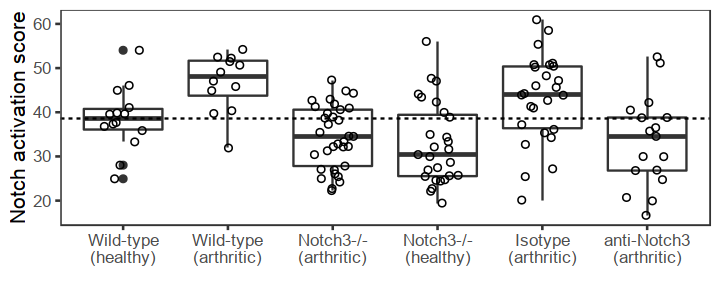

In [211]:
healthy_median <- as.numeric(data.table(plt_df)[label_nice == 'Wild-type\n(healthy)', .(median(score_notch))])

fig.size(2.5, 6)
plt_df %>% 
    ggplot(aes(label_nice, score_notch)) + 
        geom_boxplot() + 
        geom_point(shape = 21, position = position_jitter(width = .2)) + 
        theme_test(base_size = 12) + 
        geom_hline(yintercept = healthy_median, linetype = 2) + 
        labs(y = 'Notch activation score', x = '')#, title = 'Notch signaling in Pericytes/VSMCs')

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/mouse_notch_activation_boxplots.pdf', device = "pdf", 
       dpi = 300, width = 6, height = 2.5, useDingbats = FALSE)  


## 4d-g disease activity

We may need to do random effects for repeated measures. 

In [252]:
library(lme4)

In [243]:
datadir <- "/data/srlab/ik936/NOTCH/data/Manuscript_data/Figure 4/"

In [850]:
do_lineplot <- function(fname, xlab, ylab, pal, type, pval_pos, no_bottom = FALSE) {
    plt_df <- fread(file.path(datadir, fname)) 
    colnames(plt_df) <- c('V1', tail(colnames(plt_df), -1))
    plt_df <- plt_df %>% 
        data.frame() %>% 
        tidyr::gather(sample, value, -V1) %>% 
        dplyr::mutate(value = gsub("\\*", "", value), 
                      value = as.numeric(value)) %>% 
        subset(!is.na(value)) %>% 
        dplyr::rename(timepoint = V1) %>% 
        dplyr::mutate(phenotype = ifelse(grepl("Wild|Isotype|WT", sample, ignore.case = TRUE), "ctrl", "n3ko|N3KO")) 
#     pval <- broom::tidy(lm(value ~ 1 + phenotype + timepoint, plt_df))[2, 'p.value']
    
    suppressWarnings({
        lm_full <- lme4::lmer(value ~ 1 + phenotype + factor(timepoint) + (1|sample), plt_df)
        lm_null <- lme4::lmer(value ~ 1 + factor(timepoint) + (1|sample), plt_df)
        pval <- anova(lm_full, lm_null)['lm_full', 'Pr(>Chisq)']        
    })
    
    
    if (type == "smooth") {        
        plt <- plt_df %>% 
            ggplot(aes(timepoint, value, color = phenotype, fill = phenotype)) + 
                geom_smooth() 
    } else {
        plt_df %>% 
            dplyr::select(sample, phenotype) %>% 
            unique() %>% 
            with(table(phenotype)) %>% 
            print()
        
#         print(table(plt_df$phenotype))
        plt <- data.table(plt_df)[, .(mu = mean(value), sig = sd(value) / sqrt(.N)), by = .(phenotype, timepoint)] %>%
            ggplot(aes(timepoint, mu, color = phenotype, fill = phenotype)) + 
                geom_point() + 
                geom_line() + 
                geom_errorbar(aes(ymin = mu - sig, ymax = mu + sig), width = .5) 
    }
    plt <- plt + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        scale_color_manual(values = pal) + 
        scale_fill_manual(values = pal) + 
        scale_x_continuous(breaks = seq(0, 20, 1)) + 
        guides(color = FALSE, fill = FALSE) + 
        labs(subtitle = sprintf("p=%.2e", pval))
    
    if (no_bottom) {
        plt + theme(axis.ticks = element_line(size = .75), 
                  axis.line.y.left = element_line(size = .75), 
                  axis.line.x.bottom = element_line(size = .75), 
                  plot.title = element_text(hjust = .5),
                  axis.title.y = element_text(size = 20), 
                  axis.text.x = element_blank(), axis.ticks.x = element_blank(),
                  axis.title.x = element_blank(), axis.line.x = element_blank()) 
        
    } else {
        plt + theme(axis.ticks = element_line(size = .75), 
              axis.line.y.left = element_line(size = .75), 
              axis.line.x.bottom = element_line(size = .75), 
              plot.title = element_text(hjust = .5), 
              axis.title.y = element_text(size = 20), 
              axis.title.x = element_text(size = 20))       
    }
}

refitting model(s) with ML (instead of REML)


phenotype
     ctrl n3ko|N3KO 
       14        16 


refitting model(s) with ML (instead of REML)


phenotype
     ctrl n3ko|N3KO 
       14        16 


refitting model(s) with ML (instead of REML)


phenotype
     ctrl n3ko|N3KO 
       20        20 


refitting model(s) with ML (instead of REML)


phenotype
     ctrl n3ko|N3KO 
       20        20 


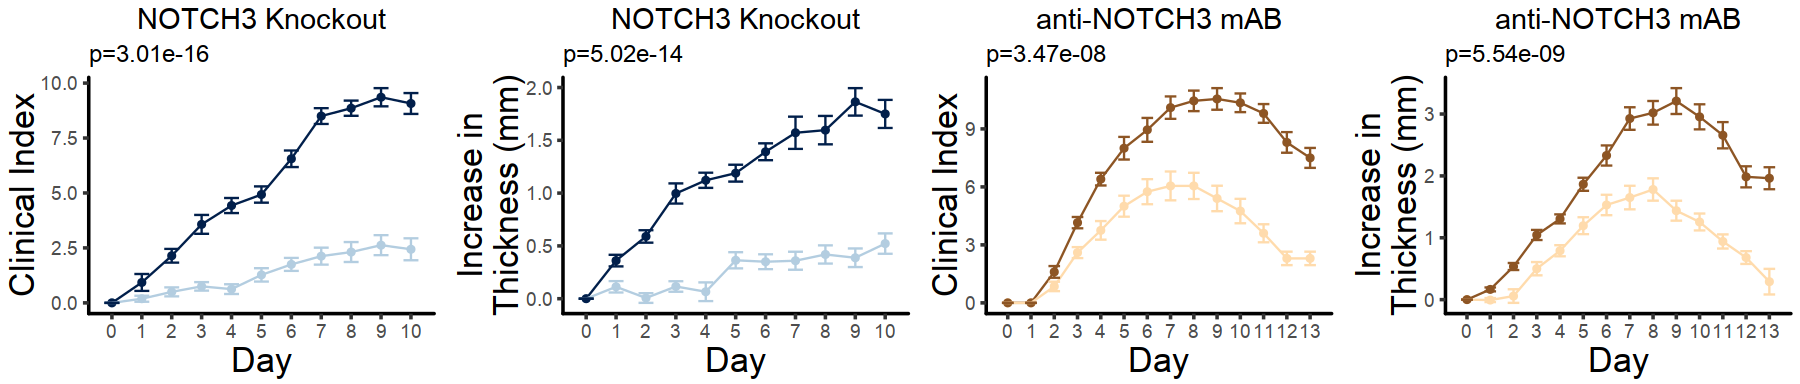

In [851]:
options(repr.plot.height = 3.2, repr.plot.width = 15)
# type <- "smooth" 
type <- "line"


palette_histology <- c('#011f4b', '#b3cde0', '#8d5524', '#ffdbac')


do_lineplot("n3KO clinical index.txt", "Day", 
# do_lineplot("N3KO vs WT arthritis clinical index.txt", "Day", 
            "Clinical Index", palette_histology[1:2], type, 
            c(2, 9), no_bottom = FALSE) +
    labs(title = "NOTCH3 Knockout", y = 'Clinical Index', x = 'Day') + 
do_lineplot("n3KO joint thickness.txt", "Day", 
# do_lineplot("N3KO vs WT arthritis joint thickness.txt", "Day", 
            "Increase in Joint\nThickness (mm)", palette_histology[1:2], type, 
            c(2, 2)) +
    labs(title = "NOTCH3 Knockout", y = 'Increase in\nThickness (mm)', x = 'Day') + 
do_lineplot("anti-N3 mAB vs isotype arthritis clinical index.txt", "Day", 
            "Clinical Index", palette_histology[3:4], type, 
            c(2, 10.5), no_bottom = FALSE) +
    labs(title = "anti-NOTCH3 mAB", y = 'Clinical Index', x = 'Day') + 
do_lineplot("anti-N3 mAB vs isotype arthritis joint thickness.txt", "Day", 
            "Increase in Joint\nThickness (mm)", palette_histology[3:4], type, 
            c(2, 3.5)) + 
    labs(title = "anti-NOTCH3 mAB", y = 'Increase in\nThickness (mm)', x = 'Day') + 
patchwork::plot_layout(byrow = FALSE, nrow = 1)

ggsave('/data/srlab/ik936/NOTCH/paper/figure4/disease_activity.pdf', device = "pdf", 
       dpi = 300, width = 15, height = 3.2, useDingbats = FALSE)

# Tables

## Markers

In [303]:
my_list <- list(
    tissue$markers$auc %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, AUC, -symbol),
    tissue$markers$fdr %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, FDR, -symbol),
    tissue$markers$lfc %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, logFoldChange, -symbol),
    tissue$markers$means %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, averageExpression, -symbol),
    tissue$markers$pct_in %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, percentNonZero, -symbol)
)


dge_tissue <- Reduce(dplyr::inner_join, my_list) %>% dplyr::mutate(dataset = 'synovialTissue')


my_list <- list(
    joint$markers_mm2$auc %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, AUC, -symbol),
    joint$markers_mm2$fdr %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, FDR, -symbol),
    joint$markers_mm2$lfc %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, logFoldChange, -symbol),
    joint$markers_mm2$means %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, averageExpression, -symbol),
    joint$markers_mm2$pct_in %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, percentNonZero, -symbol)
)


dge_organoid <- Reduce(dplyr::inner_join, my_list) %>% dplyr::mutate(dataset = 'coculturedOrganoid')


Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")


In [306]:
rbind(dge_tissue, dge_organoid) %>% 
    dplyr::select(dataset, cell_type, symbol, AUC, FDR, logFoldChange, averageExpression, percentNonZero) %>% 
    fwrite('/data/srlab/ik936/NOTCH/paper/table_markers.csv', sep = ',')    

## IF

In [ ]:
data_if %>% dplyr::select(Sample, Image.number, center_x, center_y, THY1 = CD90,
                          PRG4 = Lubricin, VWF, MCAM = CD146, region = cell_type, 
                          disease, ncells_image, thy1_prg4_ratio = ratio, is_ec,
                          dist_EC = dist_EC2) %>% 
    subset(ncells_image > 1000) %>% 
    fwrite('/data/srlab/ik936/NOTCH/paper/table_if.csv', sep = ',')



## Ligand Receptors

In [281]:
x <- tissue$lr_df_st
colnames(x) <- c('ligand', 'receptor', 'ligand_fdr', 'ligand_percentNonZero', 'receptor_fdr', 'receptor_percentNonZero')
y <- joint$lr_df_st
colnames(y) <- c('ligand', 'receptor', 'ligand_fdr', 'ligand_percentNonZero', 'receptor_fdr', 'receptor_percentNonZero')


In [285]:
dplyr::full_join(x, y, by = c('ligand', 'receptor'), suffix = c('_synovialTissue', 'organoid')) %>% 
    fwrite('/data/srlab/ik936/NOTCH/paper/table_lr.csv', sep = ',')

## Stimulation DGE

In [308]:
with(bulk, {
    dplyr::full_join(
        dge_jag1 %>% dplyr::select(-rank),
        dge_dll4 %>% dplyr::select(-rank), 
        by = c('symbol'), 
        suffix = c('_JAG1', 'DLL4')
    ) %>% 
    fwrite('/data/srlab/ik936/NOTCH/paper/table_stim.csv', sep = ',')        
})


# Old

## Endothelial RA vs OA enrichment

Decide on arterial and venous genesets

In [865]:
# genesets <- list(
#     arterial = markers_endo %>%
#         subset(padj < .05 & auc > .6 & group == 'Arterial') %>% 
#         with(feature),
#     venous = markers_endo %>%
#         subset(padj < .05 & auc > .6 & group == 'Venous') %>% 
#         with(feature)
# )

# lapply(genesets, length)

Get bulk endothelial data 

In [866]:
# library(openxlsx)
# X <- openxlsx::read.xlsx('../data/bulk_rnaseq_fibro_endo.xlsx', 1, colNames = FALSE) %>% t
# colnames(X) <- as.character(X[1, ])
# X <- X[2:nrow(X), ]

In [867]:
# meta_bulk <- X[, 1:10] %>% data.frame()
# exprs_bulk <- t(X[, 11:ncol(X)])
# exprs_bulk <- matrix(as.numeric(exprs_bulk), nrow = nrow(exprs_bulk), dimnames = dimnames(exprs_bulk)) 

# idx <- which(meta_bulk$Cell.type == 'Endothelial')
# meta_bulk <- meta_bulk[idx, ]
# exprs_bulk <- exprs_bulk[, idx] %>% normalizeData(scaling_factor = 1e6, method = 'log')


In [868]:
# score_df <- Reduce(cbind, lapply(genesets, function(genes) {
#     genes <- intersect(row.names(exprs_bulk), genes)
#     as.numeric(colSums(exprs_bulk[genes, ], na.rm = TRUE))
# })) %>% data.frame()
# colnames(score_df) <- names(genesets)


In [869]:
# # presto::sumGroups(exprs_bulk, )
# length(genes_use)

# plt_df <- meta_bulk %>% 
#     data.frame() %>% 
#     cbind(score_df) %>% 
#     tidyr::gather(key, val, arterial, venous) 

# # data.table(plt_df)[, broom::tidy(wilcox.test(val ~ Disease)), by = key]
# cor_res <- data.table(plt_df)[, broom::tidy(t.test(val ~ Disease)), by = key]

# fig.size(2.5, 6)
# plt_df %>%
# #     subset(`Cell.type` == 'Endothelial') %>% 
#     dplyr::inner_join(cor_res) %>% 
#     dplyr::mutate(key = sprintf('%s (p=%.2f)', key, p.value / 2)) %>% 
#     ggplot(aes(Disease, val)) + 
#         geom_boxplot() + 
#         geom_jitter() + 
#         facet_wrap(~key, scales = 'free') + 
#         theme_tufte(base_size = 12) + geom_rangeframe() + 
#         labs(x = 'Disease', y = 'Geneset Score') + 
#         NULL

In [766]:
# data.table(plt_df)[, broom::tidy(lm(val ~ Disease + as.numeric(Endothelial.cells))), by = key]

In [272]:
# fig.size(3, 5)
# data_df <- fread("/data/srlab/ik936/NOTCH/data/Manuscript_data/cumulative histological score in arthritis mice.txt")
# data_df %<>% data.frame() %>% 
#     tidyr::gather(type, value, -V1) %>% 
#     dplyr::mutate(type = gsub('\\..*', '', type)) %>% 
#     identity()

In [860]:
# fig.size(4, 5)
# data_df <- data_df %>% 
#     subset(!is.na(value)) %>% 
#     dplyr::mutate(type = factor(type, c('WT', 'Notch3', 'Isotype', 'anti'))) %>% 
#     dplyr::mutate(V1 = factor(V1, c('Synovitis', 'Pannus', 'Joint space exudate', 'Cartilage degradation', 'Bone erosion'))) 

# data_df %>% 
#     ggplot(aes(V1, value)) + 
#         geom_boxplot(aes(color = type)) +         
#         scale_color_manual(values = palette_histology) + 
#         scale_fill_manual(values = palette_histology) + 
#         theme_tufte(base_size = 14, base_family = "Helvetica") + geom_rangeframe() + 
#         theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
#         labs(y = 'Histology Score', x = '', fill = '', color = '') + 
#         guides(color = FALSE) + 
#         NULL

# ggsave('/data/srlab/ik936/NOTCH/paper/figure4/histology.pdf', device = "pdf", 
#        dpi = 300, width = 5, height = 4, useDingbats = FALSE)



In [861]:
# data.table(data_df)[
#     type %in% c('WT', 'Notch3'), 
#     data.table(broom::tidy(lm(value ~ type)))[term != '(Intercept)'], 
#     by = V1]

# data.table(data_df)[
#     type %in% c('Isotype', 'anti'), 
#     data.table(broom::tidy(lm(value ~ type)))[term != '(Intercept)'], 
#     by = V1]


## Composite erosion score

In [862]:
# # palette_histology <- c('#011f4b', '#b3cde0', '#8d5524', '#ffdbac')
# fig.size(3.5, 2.5)
# data_df <- fread("/data/srlab/ik936/NOTCH/data/Manuscript_data/Figure 4/µCT score.txt") %>% t %>% data.frame() %>% 
#     tibble::rownames_to_column("id") %>%
#     dplyr::mutate(type = ifelse(grepl('Isotype', id), 'Isotype\ncontrol', 'Anti-N3 mAB')) %>% 
#     dplyr::mutate(type = factor(type, c('Isotype\ncontrol', 'Anti-N3 mAB'))) %>% 
#     subset(!is.na(`.`)) 

# data_df %>% 
#     ggplot(aes(type, `.`)) + 
#         geom_boxplot(aes(fill = type)) +
#         geom_point(aes(fill = type), shape = 21, 
#                    position = position_jitterdodge(jitter.width = .5, jitter.height = 0), 
#                    size = 3) + 
# #         geom_boxplot(aes(color = type)) +
#         theme_tufte(base_size = 14, base_family = "Helvetica") + geom_rangeframe() + 
#         theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
#         labs(y = 'Composite erosion score', x = '', fill = '', color = '') + 
#         guides(color = FALSE, fill = FALSE) + 
#         scale_color_manual(values = palette_histology[3:4]) + 
#         scale_fill_manual(values = palette_histology[3:4]) + 
#         NULL


# ggsave('/data/srlab/ik936/NOTCH/paper/figure4/erosion.pdf', device = "pdf", 
#        dpi = 300, width = 2.5, height = 3.5, useDingbats = FALSE)
